## Import packages

In [1]:

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
from config import opt
from models import FlowersConvModel
from utils import train_model, get_val_metrics, get_images_paths, get_train_test_split, show_tensor_images, init_seeds
from datasets import FlowersDataset
from datasets.preprocessing import train_transformations, val_transformations

In [3]:
init_seeds(opt.seed)

## Prepare dataset

In [4]:
num_classes = len(set(opt.idx_to_class.keys()))

In [5]:
data_df = get_images_paths(opt=opt)
train_df, val_df = get_train_test_split(df=data_df, opt=opt)

In [6]:
data_df.label.value_counts()

4    602
0    518
2    472
3    420
1    239
Name: label, dtype: int64

In [7]:
train_dataset = FlowersDataset(
    img_paths=train_df['path'].values.copy(),
    labels=train_df['label'].values.copy(),
    num_classes=num_classes,
    transform=train_transformations,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

val_dataset = FlowersDataset(
    img_paths=val_df['path'].values.copy(),
    labels=val_df['label'].values.copy(),
    num_classes=num_classes,
    transform=val_transformations,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

val_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

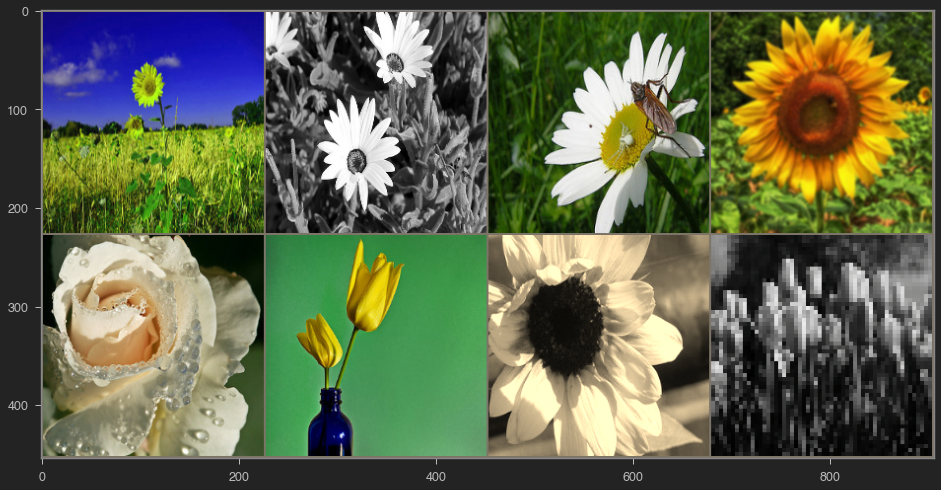

In [8]:
show_tensor_images(next(iter(train_dataloader))['image'], opt.norm_mean, opt.norm_std)

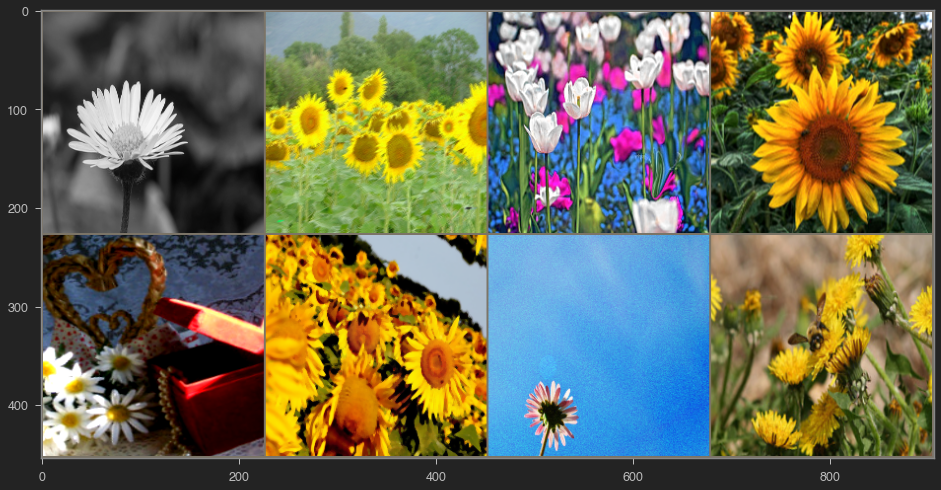

In [9]:
show_tensor_images(next(iter(val_dataloader))['image'], opt.norm_mean, opt.norm_std)

## Training

In [10]:
model = FlowersConvModel(
    encoder_name=opt.encoder_name, pretrained=opt.pretrained, num_classes=num_classes
).to(opt.device)
# model.freeze_middle_layers()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/romankryvokhyzha/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:23<00:00, 1.98MB/s]


In [11]:
summary(model, input_size=(3, opt.img_height, opt.img_width), batch_size=opt.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [12]:
train_model(model, optimizer, scheduler, criterion, train_dataloader, val_dataloader, opt, target_metric='f1_avg', best_target_metric=-np.inf)

Epoch: [0][ 0/57]	Time  7.552 ( 7.552)	Data  1.713 ( 1.713)	Loss 1.5373e+00 (1.5373e+00)	Acc   0.31 (  0.31)	F1   0.26 (  0.26)
Epoch: [0][10/57]	Time  4.330 ( 4.710)	Data  0.002 ( 0.158)	Loss 4.7266e-01 (9.2667e-01)	Acc   0.81 (  0.62)	F1   0.81 (  0.61)
Epoch: [0][20/57]	Time  4.283 ( 4.692)	Data  0.003 ( 0.084)	Loss 3.6144e-01 (6.9423e-01)	Acc   0.88 (  0.73)	F1   0.88 (  0.73)
Epoch: [0][30/57]	Time  4.317 ( 4.587)	Data  0.003 ( 0.058)	Loss 5.4784e-01 (6.2900e-01)	Acc   0.81 (  0.76)	F1   0.83 (  0.76)
Epoch: [0][40/57]	Time  4.375 ( 4.545)	Data  0.002 ( 0.044)	Loss 6.7532e-01 (5.7528e-01)	Acc   0.81 (  0.78)	F1   0.83 (  0.78)
Epoch: [0][50/57]	Time  4.263 ( 4.510)	Data  0.002 ( 0.036)	Loss 3.7024e-01 (5.3167e-01)	Acc   0.88 (  0.79)	F1   0.91 (  0.80)
Val: [ 0/57]	Time  2.555 ( 2.555)	Loss 3.6427e-01 (3.6427e-01)	Acc   0.84 (  0.84)	F1   0.85 (  0.85)
Val: [10/57]	Time  0.881 ( 1.041)	Loss 1.7441e-01 (2.0462e-01)	Acc   0.91 (  0.93)	F1   0.91 (  0.93)
Val: [20/57]	Time  0.887 ( 0

## Model performance metrics

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

In [14]:
model = FlowersConvModel(
    encoder_name=opt.encoder_name, pretrained=opt.pretrained, num_classes=num_classes
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'))
model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [15]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_dataloader, model, opt.device)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 57/57 [01:10<00:00,  1.24s/it]

Accuracy: 0.973
F1: 0.973
Precision: 0.974
Recall: 0.973


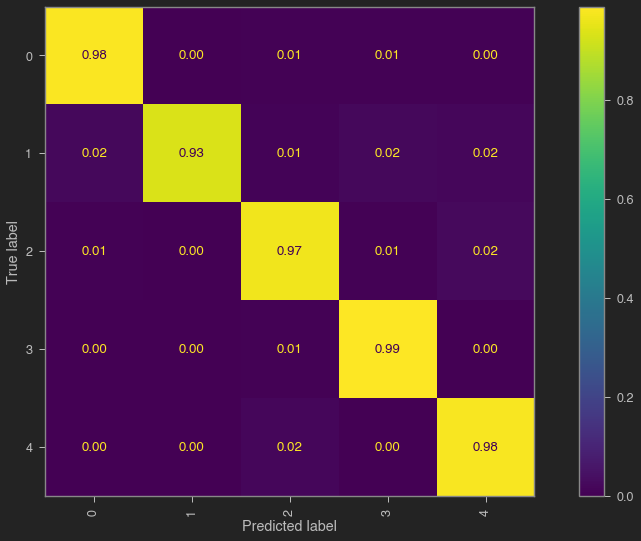

In [16]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

## Inference

In [17]:
from utils.loops import infer_folder, infer_one_file

In [18]:
image_path = '../data/daisy/10712722853_5632165b04.jpg'
infer_one_file(
    image_path, model, opt.device, transform=val_transformations,
    use_descriptors_as_features=opt.use_descriptors_as_features, features_type=opt.features_type
)

0

In [19]:
folder_path = '../data/daisy'
result = infer_folder(
    folder_path, model, opt.device, image_ext='jpg',
    transform=val_transformations,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type
)
result[:5]

[('../data/daisy/14167534527_781ceb1b7a_n.jpg', 0),
 ('../data/daisy/476857510_d2b30175de_n.jpg', 0),
 ('../data/daisy/521762040_f26f2e08dd.jpg', 0),
 ('../data/daisy/7320089276_87b544e341.jpg', 0),
 ('../data/daisy/721595842_bacd80a6ac.jpg', 0)]